Image Rotation
========

A consideration of Unser et al.


In [3]:
import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rotate as ski_rotate
from scipy.interpolate import interp1d

%matplotlib inline
def show(img):
    dummy=plt.imshow(img,cmap='gray')

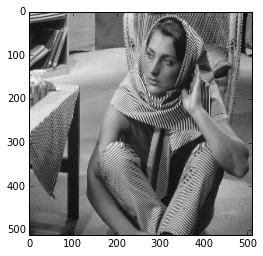

In [4]:
barbara=skio.imread("Data/barbara.bmp")
show(barbara)

In [5]:
def rotate_fullcircle(img,steps,rotation_algorithm):
    out=img.copy()
    angle=360./steps
    for i in range(steps):
        out=rotation_algorithm(out,angle)
    return out

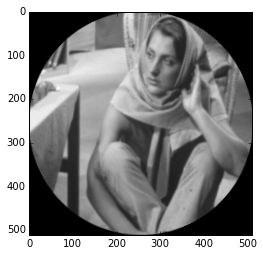

In [6]:
img=rotate_fullcircle(barbara,15,lambda x,a:ski_rotate(x,a,order=1))
show(img)

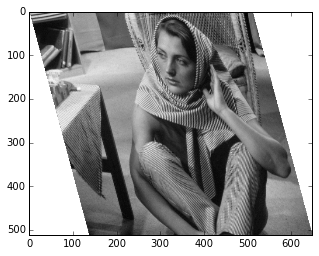

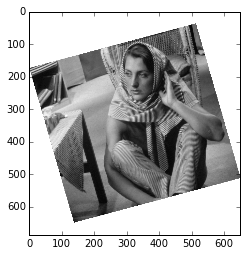

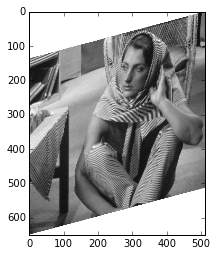

In [7]:
# allowable kinds
#‘linear’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic, ‘cubic’ or integer order
# but some seem buggy and apparently crash the kernel
def xshear(img,s,kind='linear'): 
    offset=int(np.ceil(s*img.shape[0]))
    # this tweaks the placement so the center always ends up in the actual center
    shift=(offset - s*np.float(img.shape[0]))/2.
    newsize=(img.shape[0],np.abs(offset)+img.shape[1])
    if offset<0:
        offset=abs(offset)
    else:
        offset=0
    out=np.zeros(newsize)
    for row in range(img.shape[0]):
       f=interp1d(range(img.shape[1]),img[row,:],kind=kind,bounds_error=False)
       pts=np.asarray(range(newsize[1]))-shift-offset-s*np.float(row)
       out[row,:]=f(pts)
    return out

def yshear(img,s,kind='linear',ctr=(0,0)):
    #inefficient, but avoids code duplication
    tmp1=np.rot90(img,k=1)
    tmp2=xshear(tmp1,s,kind)
    return np.rot90(tmp2,k=-1)
    
    
z=xshear(barbara,np.tan(np.deg2rad(15)),'linear')
show(z)
plt.show()
z=yshear(z,np.tan(np.deg2rad(15)))
show(z)
plt.show()
z=yshear(barbara,np.tan(np.deg2rad(15)))
show(z)
plt.show()

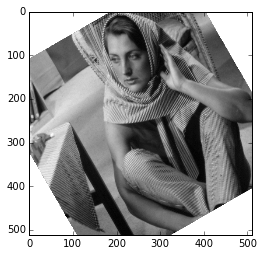

In [9]:
def unser_rotate(img,angle,kind):
    xs=np.tan(np.deg2rad(angle)/2.)
    ys=np.sin(np.deg2rad(angle))
    tmp1=xshear(img,xs,kind)
    tmp2=yshear(tmp1,ys,kind)
    tmp3=xshear(tmp2,xs,kind)
    a,b=tmp3.shape
    c,d=img.shape
    return tmp3[(a-c)//2:(a-c)//2+c,(b-d)//2:(b-d)//2+d] 

z=unser_rotate(barbara,30,'linear')
show(z)




In [ ]:
img=rotate_fullcircle(barbara,15,lambda x,a:unser_rotate(x,a,'cubic'))
show(img)